In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import argparse
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import Deconvolution
from captum.attr import Saliency
from captum.attr import GuidedBackprop
from captum.attr import GuidedGradCam
from captum.attr import InputXGradient
from captum.attr import DeepLift
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import Occlusion
from captum.attr import visualization as viz

from captum.attr import GradientShap

In [2]:
# Load the model(resnet 18) & dataset
model=models.resnet18(pretrained=True)
model=model.eval()

In [3]:
# Load labels
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
labels_path = 'imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json: Unknown/unsupported protocol.


In [4]:
# Image Load & Preprocessing
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('pome.jpg').convert('RGB')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [5]:
# Predict the class of the input image
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
score=prediction_score.squeeze().item()
print('Predicted:', predicted_label, '%4.2f'%(score*100),'%', '(',score,')')

Predicted: Pomeranian 94.09 % ( 0.9409205913543701 )


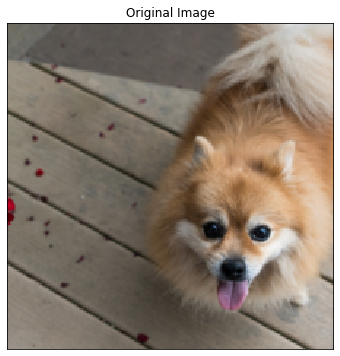

In [6]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#6666ff'),
                                                  (0.25, '#33ff00'),
                                                  (1.0, '#ff0000')], N=256)

_=viz.visualize_image_attr(None,np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),method="original_image", 
  title="Original Image")

C:\Users\beatr\anaconda3\lib\site-packages\captum\_utils\gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\beatr\anaconda3\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
C:\Users\beatr\anaconda3\lib\site-packages\torch\autograd\__init__.py:204: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  inputs, allow_unused)


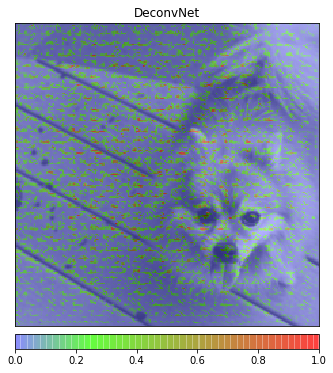

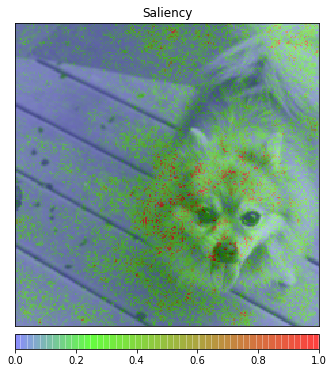

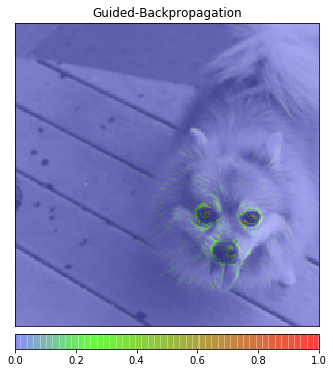

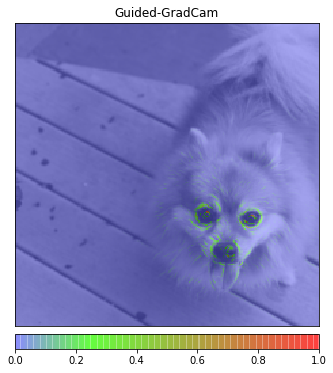

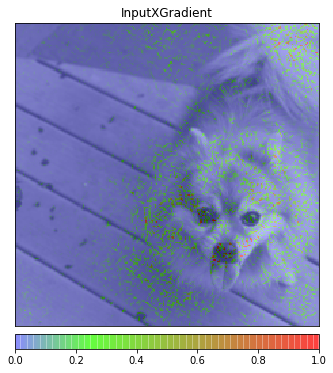

In [7]:
methods=[Deconvolution, Saliency, GuidedBackprop, GuidedGradCam,
        InputXGradient, DeepLift, IntegratedGradients]

# DeconvNet
deconv=Deconvolution(model)
deconv_attributions=deconv.attribute(input, target=pred_label_idx)
_ = viz.visualize_image_attr(np.transpose(deconv_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "blended_heat_map",
                                      sign= "positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      title="DeconvNet")
# Saliency
saliency=Saliency(model)
saliency_attributions=saliency.attribute(input,target=pred_label_idx,abs=True)
_ = viz.visualize_image_attr(np.transpose(saliency_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "blended_heat_map",
                                      sign= "positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                            title="Saliency")
# Guided-Backpropagation
gbp=GuidedBackprop(model)
gbp_attributions=gbp.attribute(input,target=pred_label_idx)
_ = viz.visualize_image_attr(np.transpose(gbp_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "blended_heat_map",
                                      sign= "positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                            title="Guided-Backpropagation")
# Guided-GradCam
ggc=GuidedGradCam(model,model.layer4)
ggc_attributions=ggc.attribute(input,target=pred_label_idx)
_ = viz.visualize_image_attr(np.transpose(ggc_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "blended_heat_map",
                                      sign="positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                            title="Guided-GradCam")
# InputXGradient
ixg=InputXGradient(model)
ixg_attributions=ixg.attribute(input,target=pred_label_idx)
_ = viz.visualize_image_attr(np.transpose(ixg_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      method= "blended_heat_map",
                                      sign="positive",
                                      cmap=default_cmap,
                                      show_colorbar=True,
                            title="InputXGradient")


In [8]:
# IntergratedGradients
ig=IntegratedGradients(model)
ig_attributions=ig.attribute(input,target=pred_label_idx,n_steps=200)
_ = viz.visualize_image_attr(np.transpose(ig_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1,
                            title="Integrated Gradients")

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 642252800 bytes. Buy new RAM!

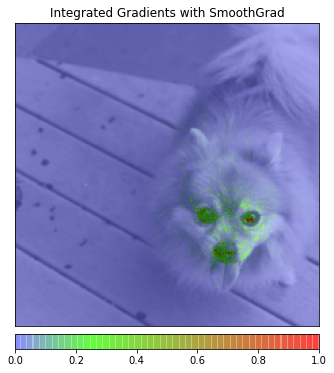

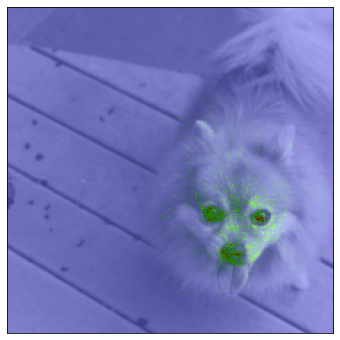

In [21]:
# IntegratedGradients with SmoothGrad
ignt=IntegratedGradients(model)
nt=NoiseTunnel(ignt)
ignt_attributions=nt.attribute(input, target=pred_label_idx, nt_type='smoothgrad_sq', n_samples=10)
_ = viz.visualize_image_attr(np.transpose(ignt_attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='blended_heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                        sign='positive',
                            title="Integrated Gradients with SmoothGrad")

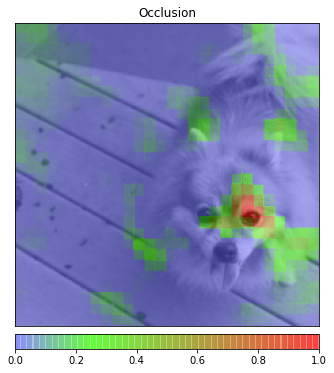

In [11]:
# Occlusion-based attribution
oc=Occlusion(model)
oc_attributions=oc.attribute(input,strides=(3,8,8),
                            target=pred_label_idx,
                            sliding_window_shapes=(3,15,15),
                            baselines=0)
# (1,2,0)을 안넣으면 이미지가 좌로 90도 돌아가서 출력됨
_=viz.visualize_image_attr(np.transpose(oc_attributions.squeeze().cpu().detach().numpy(),(1,2,0)),
                           np.transpose(transformed_img.squeeze().cpu().detach().numpy(),(1,2,0)),
                            method='blended_heat_map',
                            cmap=default_cmap,
                            show_colorbar=True,
                            sign='positive',
                            outlier_perc=2,
                            title="Occlusion")